In [1]:
import numpy as np
import pandas as pd
import os
import gc

## 抽取少量样本
由于只有user_log的数据量比较大，因此只对user_log进行抽取，且按user_id分组抽取

In [2]:
from sklearn.model_selection import train_test_split

In [14]:
dir_path = './data/'
user_log = pd.read_csv(dir_path + 'user_log_format1.csv')
_, df_sample = train_test_split(user_log, test_size=0.05, random_state=2021, stratify=user_log['user_id'])

In [21]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746267 entries, 10245626 to 39529807
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 167.6 MB


In [32]:
# df_sample.reset_index(drop=True).to_csv(dir_path + 'user_log_sample.csv', index=False)

In [37]:
del _
gc.collect()

2709

## 加载数据

In [12]:
def reduce_mem_usage(df, verbose=True):
    """内存优化"""
    numeric_feas = df.select_dtypes('number').columns
    uint_feas = df[numeric_feas].loc[:, df[numeric_feas].min() >= 0].columns
    start_mem = df.memory_usage().sum() / 1024 ** 2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    other_feas = [f for f in df.columns if f not in uint_feas]
    for col in uint_feas:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
    for col in other_feas:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
dir_path = './data/'
user_info = pd.read_csv(dir_path + 'user_info_format1.csv')
user_log = pd.read_csv(dir_path + 'user_log_format1.csv')  # 全样本
# user_log = pd.read_csv(dir_path + 'user_log_sample.csv')  # 小样本版本
train = pd.read_csv(dir_path + 'train_format1.csv')
test = pd.read_csv(dir_path + 'test_format1.csv')

In [13]:
# 压缩内存
user_log = reduce_mem_usage(user_log)

Memory usage after optimization is: 1519.05 MB
Decreased by 48.2%


In [4]:
df = pd.concat([train, test]).drop('prob', axis=1)
df['label'] = df['label'].fillna(-1)
df.sample(3)

,user_id,merchant_id,label
175131,376193,309,-1.0
4798,231822,4287,-1.0
88697,192901,2403,0.0


In [5]:
user_info.head(3)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0


In [14]:
user_log.head(3)

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,1900-08-29,0
1,328862,844400,1271,2882,2661.0,1900-08-29,0
2,328862,575153,1271,2882,2661.0,1900-08-29,0


In [7]:
train.head(3)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1


In [8]:
test.head(3)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN


## 数据预处理

### 缺失值填充

In [9]:
user_info['age_range'] = user_info['age_range'].fillna(0).astype('int8')
user_info['gender'] = user_info['gender'].fillna(2).astype('int8')
user_log['brand_id'].fillna(0, inplace=True)

### 特征构造

#### 用户维度

In [10]:
# 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(user_info['age_range'], prefix='age')
user_info = pd.concat([user_info, temp], axis=1)
temp = pd.get_dummies(user_info['gender'], prefix='g')
user_info = pd.concat([user_info, temp], axis=1)
user_info.drop(['age_range', 'gender'], axis=1, inplace=True)
df = df.merge(user_info, how='left', on='user_id')
df.head(3)

,user_id,merchant_id,label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_1,g_2
0,34176,3906,0.0,0,0,0,0,0,0,1,0,0,1,0,0
1,34176,121,0.0,0,0,0,0,0,0,1,0,0,1,0,0
2,34176,4356,1.0,0,0,0,0,0,0,1,0,0,1,0,0


In [11]:
# 统一字段名
user_log.rename(columns={'seller_id': 'merchant_id'}, inplace=True)
# 时间戳处理
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d')
user_log.head(3)

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,1900-08-29,0
1,328862,844400,1271,2882,2661.0,1900-08-29,0
2,328862,575153,1271,2882,2661.0,1900-08-29,0


In [16]:
g_user = user_log.groupby('user_id')
# 时间间隔特征
temp = g_user['time_stamp'].agg((('last_time', 'max'), ('first_time', 'min')))
temp['day_d1'] = (temp['last_time'] - temp['first_time']).dt.days
temp['day_d2'] = (user_log['time_stamp'].max() - temp['first_time']).dt.days
temp['day_d3'] = (user_log['time_stamp'].max() - temp['last_time']).dt.days
temp.drop(['last_time', 'first_time'], axis=1, inplace=True)
df = df.merge(temp, how='left', on='user_id')
# 用户交互行为数量 u_ct
temp = g_user.size().rename('u_ct')
df = df.merge(temp, how='left', on='user_id')
# 使用agg (aggregation)基于列的聚合操作，统计唯一值个数 item_id, cat_id, merchant_id, brand_id
dict_count = {'i': 'item_id', 'c': 'cat_id', 'm': 'merchant_id', 'b': 'brand_id'}
for k, i in dict_count.items():
    temp = g_user[i].agg([('u_' + k, 'nunique')])
    df = df.merge(temp, how='left', on='user_id')
# 统计操作类型为0，1，2，3的个数
temp = g_user['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'u_a0', 1:'u_a1', 2:'u_a2', 3:'u_a3'}).fillna(0)
df = df.merge(temp, on='user_id', how='left')
del g_user
gc.collect()
df.head(3)

,user_id,merchant_id,label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,day_d3,u_ct,u_i,u_c,u_m,u_b,u_a0,u_a1,u_a2,u_a3
0,34176,3906,0.0,0,0,0,0,0,0,1,...,1,451,256,45,109,108,410.0,0.0,34.0,7.0
1,34176,121,0.0,0,0,0,0,0,0,1,...,1,451,256,45,109,108,410.0,0.0,34.0,7.0
2,34176,4356,1.0,0,0,0,0,0,0,1,...,1,451,256,45,109,108,410.0,0.0,34.0,7.0


#### 商家维度

In [17]:
g_merchant = user_log.groupby(['merchant_id'])
# 商家被交互行为数量 m_ct
temp = g_merchant.size().rename('m_ct')
df = df.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = g_merchant['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m_u', 'item_id':'m_i', 'cat_id':'m_c', 'brand_id':'m_b'})
df = df.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = g_merchant['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'m_a0', 1:'m_a1', 2:'m_a2', 3:'m_a3'}).fillna(0)  # 缺失值填充0
df = df.merge(temp, on='merchant_id', how='left')
del g_merchant
gc.collect()
df.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,user_id,merchant_id,label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,u_a3,m_ct,m_u,m_i,m_c,m_b,m_a0,m_a1,m_a2,m_a3
0,34176,3906,0.0,0,0,0,0,0,0,1,...,7.0,16269,5819,308,20,2,14870.0,28.0,410.0,961.0
1,34176,121,0.0,0,0,0,0,0,0,1,...,7.0,79865,10931,1179,26,2,72265.0,121.0,4780.0,2699.0
2,34176,4356,1.0,0,0,0,0,0,0,1,...,7.0,7269,2281,67,15,2,6094.0,16.0,963.0,196.0


#### 用户与商家的交互

In [18]:
g_um = user_log.groupby(['user_id', 'merchant_id'])
# 统计行为个数
temp = g_um.size().reset_index().rename(columns={0:'um'}) 
df = df.merge(temp, on=['user_id', 'merchant_id'], how='left')
# 统计与item_id, cat_id, brand_id交互的唯一值
temp = g_um['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(
    columns={'item_id':'um_i', 'cat_id':'um_c', 'brand_id':'um_b'}) 
df = df.merge(temp, on=['user_id', 'merchant_id'], how='left')
# 统计不同action_type唯一个数
temp = g_um['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'um_a0', 1:'um_a1', 2:'um_a2', 3:'um_a3'}).fillna(0)
df = df.merge(temp, on=['user_id', 'merchant_id'], how='left')
# 统计时间间隔
temp = g_um['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um_day'] = (temp['last'] - temp['first']).dt.days
temp.drop(['first', 'last'], axis=1, inplace=True)
df = df.merge(temp, on=['user_id', 'merchant_id'], how='left') 
del g_um
gc.collect()
df.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,user_id,merchant_id,label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,m_a3,um,um_i,um_c,um_b,um_a0,um_a1,um_a2,um_a3,um_day
0,34176,3906,0.0,0,0,0,0,0,0,1,...,961.0,39,20,6,1,36.0,0.0,1.0,2.0,22
1,34176,121,0.0,0,0,0,0,0,0,1,...,2699.0,14,1,1,1,13.0,0.0,1.0,0.0,3
2,34176,4356,1.0,0,0,0,0,0,0,1,...,196.0,18,2,1,1,12.0,0.0,6.0,0.0,1


In [22]:
del temp
del user_log
gc.collect()

100

In [20]:
#用户购买点击比
df['u_r'] = df['u_a2']/df['u_a0'] 
#商家购买点击比
df['m_r'] = df['m_a2']/df['m_a0'] 
#不同用户不同商家购买点击比
df['um_r'] = df['um_a2']/df['um_a0']
df.fillna(0, inplace=True)
df.head(3)

,user_id,merchant_id,label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,um_c,um_b,um_a0,um_a1,um_a2,um_a3,um_day,u_r,m_r,um_r
0,34176,3906,0.0,0,0,0,0,0,0,1,...,6,1,36.0,0.0,1.0,2.0,22,0.082927,0.027572,0.027778
1,34176,121,0.0,0,0,0,0,0,0,1,...,1,1,13.0,0.0,1.0,0.0,3,0.082927,0.066145,0.076923
2,34176,4356,1.0,0,0,0,0,0,0,1,...,1,1,12.0,0.0,6.0,0.0,1,0.082927,0.158024,0.500000


#### 分割训练数据与测试数据

In [24]:
train_data = df[df['label'] != -1]
test_data = df[df['label'] == -1].drop(['label'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del df
gc.collect()

80

### 模型训练与预测

In [25]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [26]:
# 将训练集进行切分，20%用于验证
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2)

In [29]:
# 使用XGBoost
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42    
)
model.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=50 
)

[0]	validation_0-auc:0.63590	validation_1-auc:0.62447
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.65216	validation_1-auc:0.63316
[2]	validation_0-auc:0.66292	validation_1-auc:0.63811
[3]	validation_0-auc:0.66571	validation_1-auc:0.63988
[4]	validation_0-auc:0.66816	validation_1-auc:0.64242
[5]	validation_0-auc:0.66886	validation_1-auc:0.64314
[6]	validation_0-auc:0.66849	validation_1-auc:0.64489
[7]	validation_0-auc:0.66987	validation_1-auc:0.64454
[8]	validation_0-auc:0.67127	validation_1-auc:0.64578
[9]	validation_0-auc:0.67225	validation_1-auc:0.64661
[10]	validation_0-auc:0.67361	validation_1-auc:0.64790
[11]	validation_0-auc:0.67529	validation_1-auc:0.64991
[12]	validation_0-auc:0.67763	validation_1-auc:0.65259
[13]	validation_0-auc:0.67949	validation_1-auc:0.65487
[14]	validation_0-auc:0.68064	validation_1-auc:0.65456
[15]	validation_0-auc:0.6825

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
prob = model.predict_proba(test_data)
test['prob'] = pd.Series(prob[:,1])
test.to_csv('result/prediction.csv', index=False)

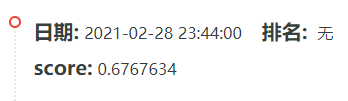

得分大于0.66

经验与想法：纠正陈老师代码一个问题是，对于time_stamp的处理错了，实际格式是月日，但陈老师按照小时分钟来处理了。时间原因，未能引入Attention机制来训练模型